In [15]:
# Imports
import torch
import torchvision                              # torch package for vision related things
import torch.nn.functional as F                 # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets         # Standard datasets
import torchvision.transforms as transforms     # Transformations we can perform on our dataset for augmentation
from torch import optim                         # For optimizers like SGD, Adam, etc.
from torch import nn                            # All neural network modules
from torchsummary import summary
from torch import Tensor
from torch.utils.data import DataLoader         # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm                           # For nice progress bar!

import os
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Union

Files already downloaded and verified
Files already downloaded and verified


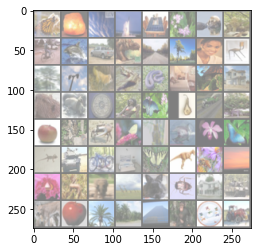

tensor(14) tensor(40) tensor(23) tensor(69) tensor(84) tensor(54) tensor(55) tensor(51) tensor(8) tensor(30) tensor(58) tensor(29) tensor(68) tensor(59) tensor(98) tensor(20) tensor(59) tensor(40) tensor(34) tensor(27) tensor(78) tensor(5) tensor(37) tensor(37) tensor(4) tensor(72) tensor(22) tensor(98) tensor(14) tensor(57) tensor(90) tensor(52) tensor(0) tensor(42) tensor(26) tensor(14) tensor(18) tensor(30) tensor(54) tensor(14) tensor(44) tensor(85) tensor(8) tensor(5) tensor(14) tensor(29) tensor(6) tensor(23) tensor(54) tensor(18) tensor(31) tensor(60) tensor(65) tensor(24) tensor(37) tensor(85) tensor(19) tensor(0) tensor(56) tensor(56) tensor(76) tensor(21) tensor(61) tensor(89)


In [16]:
################################################# datasets #################################################

# Path and Hyperparameters
#os.listdir('./drive/MyDrive/21-2-ML/')
storage = './drive/MyDrive/21-2-ML/CIFAR100/'

in_channels = 3
num_class   = 100
BS          = 64

# Apply Transformation : 
img_transformation = transforms.Compose([
                                         #transforms.RandomAffine(degrees=(-10,10), translate=(0, 0.05)),
                                         transforms.RandomHorizontalFlip(p = 0.5),
                                         transforms.ToTensor()
])

# Prepare the Dataset : 
train_data = datasets.CIFAR100(root = storage, train = True, transform = img_transformation, download = True)
test_data  = datasets.CIFAR100(root = storage, train = False, transform = img_transformation, download = True)
train_loader = DataLoader(dataset=train_data, batch_size=BS, shuffle=True)
test_loader  = DataLoader(dataset=test_data, batch_size=BS, shuffle=True)        # Shuffle for every epoch

# Check the prepared dataset : iter through the training loader
dataiter = iter(train_loader)
img, lab = dataiter.next()
def imshow(img):
    img = img / 2 + 0.5                                                          # unnormalize. Dataset images are already normalized!!
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# show images
imshow(torchvision.utils.make_grid(img))
# print labels
print(" ".join('%5s' % lab[j] for j in range(BS)))

In [17]:
print(lab.unique())  # Okay. labels are wetted properly.
print(img[0].shape)

tensor([ 0,  4,  5,  6,  8, 14, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31,
        34, 37, 40, 42, 44, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 65, 68, 69,
        72, 76, 78, 84, 85, 89, 90, 98])
torch.Size([3, 32, 32])


In [30]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Construct network : Here we're going to implement custom ResNet
# Input : 3*32*32
# Layer | output size  |  kernel/#filter/stride
# Conv1 | 16*30*30     |  3x3 / 16 / 1
# MaxPool 2x2
# Conv2 | 32*13*13     |  3x3 / 32 / 1
# Conv3 | 32*11*11     |  3x3 / 32 / 1
# Conv4 | 32*9*9       |  3x3 / 32 / 1
# FC1   | 1024         |  dropout = 0.5
# FC2   | 100          |  dropout = 0.5


# 3x3 conv block with padding
def conv3x3(in_channels, out_channels, stride = 1) -> nn.Conv2d:
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride = stride, padding = 1, bias = False)        # This prevents dimensional reduction
# 1x1 conv block that will used in downsampling
def conv1x1(in_channels, out_channels, stride = 1) -> nn.Conv2d:
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
                
# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()                            # Inherits methods in nn.Module
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.BN1   = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace = True)                        # With inplacing, we can save memory.
        self.conv2 = conv3x3(out_channels, out_channels)
        self.BN2   = nn.BatchNorm2d(out_channels)
        self.downsample = downsample                                # When we need downsampling

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.BN1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.BN2(out)

        if self.downsample is not None:
            #print(self.downsample, out.shape, x.shape)
            identity = self.downsample(x)                           # Construct a new downsample layer, and pass it to the ResBlock.
                                                                    # Downsampling : Filter-wise downsample!
        out += identity
        out = self.relu1(out)

        return out 

# ResNet body! 
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = num_class):
        super(ResNet, self).__init__()

        # Input layer elements
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn   = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # Body layer elements
        self.layer1 = self.make_layer(block, 16, layers[0])        # Stack layers[0] layers, stride = 1
        self.layer2 = self.make_layer(block, 32, layers[1], 2)     # Stack layers[1] layers, stride = 2
        self.layer3 = self.make_layer(block, 64, layers[2], 2)     # Stack layers[2] layers, stride = 2
        # Output layer elements
        self.maxpool= nn.MaxPool2d((2,2))                          # output size of 4,4. Avg/Maxpool2d는 (kernel size)
        self.fc1    = nn.Linear(64*4*4, num_class)
        #self.fc2    = nn.Linear(512, num_class)                   # Redundent
        self.dropout= nn.Dropout(p = 0.4)

    def make_layer(self, block, out_channels, blocks, stride = 1):
        downsample = None
        # If we want to downsample in filter or W/H dimension, initialize the downsample() layer. 
        if (stride != 1) or (self.in_channels != out_channels):    # When 
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        #print('Data shape:', x.shape)
        out = self.conv(x)          # 16*32*32
        out = self.bn(out)
        out = self.relu(out)        # need activation
        #print('input shape:', out.shape)
        out = self.layer1(out)      # ?
        #print('layer1 shape:', out.shape)
        out = self.layer2(out)      # ?
        #print('layer2 shape:', out.shape)
        out = self.layer3(out)      # ?
        #print('layer3 shape:', out.shape)
        out = self.maxpool(out)
        #print('shape after avgpool:', out.shape)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)

        return out

In [31]:
model = ResNet(ResBlock, [3,3,3]).to(device)
X = torch.randn(16, 3, 32, 32).to(device)
output = model(X)
print(output.size(),'\n')
summary(model, (3,32,32), device=device.type)

torch.Size([16, 100]) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
         ResBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv

In [20]:
lr_init     = 0.0009


############################ Loss function and optimization #############################
loss_func = nn.CrossEntropyLoss(reduction = 'sum')                        # Sum-up the CE loss in the minibatch
optimizer = torch.optim.Adam(model.parameters(), lr = lr_init)

##################################### Lr scheduling #####################################
# print(optimizer.param_groups) All the layer weights.. and Hyperparameters!
from torch.optim.lr_scheduler import ReduceLROnPlateau
# patience : n epoch동안 loss reduction 없으면
# factor   : factor만큼 lr에 multplication함
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5)

######################### Function that calculates lr and loss ##########################
def get_lr(opt : optimizer) -> float:
    for param_group in opt.param_groups:
        return param_group['lr']

def batch_metric(prediction, target):                        # Returns correct number of data in a minibatch. 
    onehot_pred = prediction.argmax(1, keepdim = True)       # Extracts maximum prob. index
    corrects    = onehot_pred.eq(target.view_as(onehot_pred)).sum().item()
    # .sum() -> Tensor(scalar) --> .item()->scalar! 
    return corrects                                          # Therefore metric == accuracy, and passed trough scheduler

def batch_loss(loss_func, prediction, target, optim = None):
    loss     = loss_func(prediction, target)
    corrects = batch_metric(prediction, target)

    if optim is not None:           # In the training step
        optim.zero_grad()           # zero-initialize gradients(since pytorch sums-up gradients)
        loss.backward()                 # BP
        optim.step()                # https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
    return loss.item(), corrects    # loss.item() returns a scarlar value. 

In [21]:
###################### Get loss per epoch and return metric #######################
def loss_in_epoch(model, loss_func, train_dataloader, optimizer = None) -> int:
    running_loss = 0.0
    running_corrects = 0.0
    len_data = len(train_dataloader.dataset)  # .dataset = attibutes of the whole dataset.

    for X_batch, Y_batch in train_dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        Y_pred  = model(X_batch)

        BatchLoss_train, corrects = batch_loss(loss_func, Y_pred, Y_batch, optimizer)
        running_loss             += BatchLoss_train
        #print(BatchLoss_train)

        if corrects is not None:
            running_corrects       += corrects

    loss   = running_loss / len_data          # Aggregate all losses in epoch -> divide to len(dataset)
    metric = running_corrects / len_data      # Aggregate all corrects in ''  -> divide to ''

    return loss, metric


################################ Training Function ################################
def train_model(model, params : dict) -> Union[model, dict, dict] :           # Multiple output annotation : Union[]
    # Assert parameters. 
    n_epoch     = params['n_epoch']
    optimizer   = params['optimizer']
    loss_func   = params['loss_func']
    train_dl    = params['train_dl']
    val_dl      = params['val_dl']
    lr_scheduler= params['lr_scheduler'] 

    # To store losses and accuracy:
    loss_history   = {'train' : [], 'val' : []}
    metric_history = {'train' : [], 'val' : []}

    # Record the best loss:
    best_loss = float('inf')
    
    start_time = time.time()
    for epoch in range(n_epoch):
        current_lr = get_lr(optimizer)
        print(f"Epoch [{epoch+1}/{n_epoch}], current lr = {current_lr:.8f}")

        model.train()
        train_loss, train_metric = loss_in_epoch(model, loss_func, train_dl, optimizer)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        with torch.no_grad():                                                 # Off all layers, i.e. stop update
            model.eval()                                                      # Since Dropout/norm.layers added, we turn off them in the eval.step. 
            val_loss, val_metric = loss_in_epoch(model, loss_func, val_dl)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        #if val_loss < best_loss : 
            # Here we aim to implement a storing function of the best model weights
         #   pass
        
        lr_scheduler.step(val_loss)                                           # Update lr_scheduler with metric = Accuracy
        print(f'training loss = {train_loss:.6f},  validation loss = {val_loss:.6f}, \
            accuracy = {100*val_metric:.4f},  time = {(time.time() - start_time):.3f} sec' )
        print('--'*10)

    return model, loss_history, metric_history

In [22]:
'''testlr = []
test_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
for i in range(100):
    optimizer.step()
    testlr.append(optimizer.param_groups[0]['lr'])
    #print(len(optimizer.param_groups))
    test_scheduler.step()      

plt.plot(range(100), testlr)'''

"testlr = []\ntest_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)\nfor i in range(100):\n    optimizer.step()\n    testlr.append(optimizer.param_groups[0]['lr'])\n    #print(len(optimizer.param_groups))\n    test_scheduler.step()      \n\nplt.plot(range(100), testlr)"

In [23]:
params_train = {'n_epoch'      : 50,
                'optimizer'    : optimizer,    # Adam(model.parameters(), lr = lr_init)
                'loss_func'    : loss_func,    # CrossEntropyLoss(reduction = 'sum')
                'train_dl'     : train_loader,
                'val_dl'       : test_loader,  # Here i use validation set as a test set. In practice, NEVER DO THIS!
                'lr_scheduler' : scheduler     # 
                }

model, loss_hist, metric_hist = train_model(model, params_train)

Epoch [1/50], current lr = 0.00090000
training loss = 3.957968,  validation loss = 3.295934,             accuracy = 21.7100,  time = 21.202 sec
--------------------
Epoch [2/50], current lr = 0.00090000
training loss = 3.111937,  validation loss = 2.879126,             accuracy = 28.9600,  time = 42.551 sec
--------------------
Epoch [3/50], current lr = 0.00090000
training loss = 2.666101,  validation loss = 2.405745,             accuracy = 37.7900,  time = 63.889 sec
--------------------
Epoch [4/50], current lr = 0.00090000
training loss = 2.379314,  validation loss = 2.298221,             accuracy = 41.4400,  time = 84.997 sec
--------------------
Epoch [5/50], current lr = 0.00090000
training loss = 2.181705,  validation loss = 2.056674,             accuracy = 45.3800,  time = 106.602 sec
--------------------
Epoch [6/50], current lr = 0.00090000
training loss = 2.042373,  validation loss = 2.018277,             accuracy = 46.4800,  time = 128.231 sec
--------------------
Epoch [7

In [32]:
PATH = './drive/MyDrive/21-2-ML/CIFAR100/Res18_CIFAR100_ckpt'

# torch.save(model.state_dict(), PATH)        # Save the entire model
test_model = ResNet(ResBlock, [3,3,3]).to(device)
test_model.load_state_dict(torch.load(PATH))
test_model.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
for i in range(20):
    n_accurate = 0 
    n_total    = 0

    # Sum of the accurate samples / Total test samples*100

    for X, Y in test_loader:
        n_total    += len(X)
        n_accurate += batch_metric(test_model(X.to(device)), Y.to(device))

    print(n_accurate/n_total*100)

61.38
61.260000000000005
61.22
61.67
61.19
61.56
61.56
61.41
61.27
61.0
61.19
61.28
61.650000000000006
61.53999999999999
61.25000000000001
61.199999999999996
60.96
